# Chapter 2 exercise

In [1]:
import pandas as pd
import numpy as np
from scipy import optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data = pd.read_csv('data.csv', na_values = '.')
data['PCECC96'] = pd.to_numeric(data['PCECC96'])
data['WILL5000IND'] = pd.to_numeric(data['WILL5000IND'])
data['GDPDEF'] = pd.to_numeric(data['GDPDEF'])
data['TB3MS'] = pd.to_numeric(data['TB3MS'])
data.head(5)

,DATE,PCECC96,WILL5000IND,GDPDEF,TB3MS
0,1971-01-01,3156.978,NaN,22.391,3.840000
1,1971-04-01,3185.993,1.136667,22.685,4.250000
2,1971-07-01,3211.394,1.113333,22.916,5.010000
3,1971-10-01,3264.679,1.113333,23.107,4.230000
4,1972-01-01,3307.767,1.240000,23.458,3.436667


In [3]:
data = data.rename(columns = {'PCECC96': 'Consumption',\
                       'TB3MS': 'Tbill',\
                       'WILL5000IND': 'Return',\
                       'GDPDEF': 'Deflator'})
data.head(5)

,DATE,Consumption,Return,Deflator,Tbill
0,1971-01-01,3156.978,NaN,22.391,3.840000
1,1971-04-01,3185.993,1.136667,22.685,4.250000
2,1971-07-01,3211.394,1.113333,22.916,5.010000
3,1971-10-01,3264.679,1.113333,23.107,4.230000
4,1972-01-01,3307.767,1.240000,23.458,3.436667


In [4]:
data.insert(5, "Real Return", \
            (1 + data['Return'].pct_change())/ \
            (1 + data['Deflator'].pct_change()) )
data.insert(6, "Real Tbill", \
            (1 + data['Tbill'].pct_change())/ \
            (1 + data['Deflator'].pct_change()) )
data.head(5)

,DATE,Consumption,Return,Deflator,Tbill,Real Return,Real Tbill
0,1971-01-01,3156.978,NaN,22.391,3.840000,NaN,NaN
1,1971-04-01,3185.993,1.136667,22.685,4.250000,NaN,1.092427
2,1971-07-01,3211.394,1.113333,22.916,5.010000,0.969599,1.166941
3,1971-10-01,3264.679,1.113333,23.107,4.230000,0.991734,0.837332
4,1972-01-01,3307.767,1.240000,23.458,3.436667,1.097107,0.800294


In [5]:
data = data.set_index('DATE')
data.head(5)

,Consumption,Return,Deflator,Tbill,Real Return,Real Tbill
DATE,,,,,,
1971-01-01,3156.978,NaN,22.391,3.840000,NaN,NaN
1971-04-01,3185.993,1.136667,22.685,4.250000,NaN,1.092427
1971-07-01,3211.394,1.113333,22.916,5.010000,0.969599,1.166941
1971-10-01,3264.679,1.113333,23.107,4.230000,0.991734,0.837332
1972-01-01,3307.767,1.240000,23.458,3.436667,1.097107,0.800294


In [6]:
# some functions
mu = lambda c, γ: c**(-γ)
u = lambda c, γ: c**(1-γ)/(1-γ)

### 1. Compute $\gamma$

In [7]:
β = 0.99

def SDF(γ, ct, ctp1):
    
    mtp1 = β * mu(ct, γ) / mu(ctp1, γ)
    
    return mtp1

def func5(γ):
    
    M = SDF(γ,data['Consumption'], data['Consumption'].shift(1))
    R = data['Real Return']
    
    EM = M.mean(skipna = True)
    ER = R.mean(skipna = True)
    
    covar = R.cov(M)
    
    f1 = covar + EM * ER - 1
    
    return f1

func5(0.5)

0.004973650621856729

In [8]:
opt.broyden1(func5, 1)

array(1.15788216)

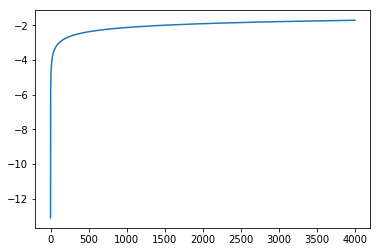

In [9]:
plt.plot(np.linspace(0.01, 4000, 4000), u(np.linspace(0.01, 4000, 4000), 1.15788216))

### 2. Reasonable?
- I think this is reasonable, as we have the utility function convex, and is reasonablly flat when it gets away from 0.
- If really want to determine, run lab experiments or take this parameter to other places and see whether that matches with the data or not.

### 3. use moment restriction equation 7

In [10]:
def func7(γ):
    
    M = SDF(γ,data['Consumption'], data['Consumption'].shift(1)).dropna()
    Rf = data['Real Tbill'].dropna()/100 # no convergence if I do not divide it by 100
    EM = M.mean()
    ERf = Rf.mean()
    
    f = 1/EM - 1 - ERf
    
    return f

func7(0.5)

0.0035138436140952946

In [11]:
opt.broyden1(func7, 1)

array(0.03196192)

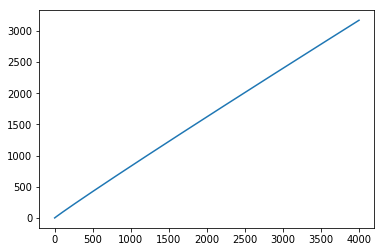

In [12]:
plt.plot(np.linspace(0.01, 4000, 4000), u(np.linspace(0.01, 4000, 4000), 0.03196192))

- the $\gamma$ is very small, which makes sense as now we are using the risk-free rate, and there should be no risk aversion.

### 4: Using both equations 5 and 7

In [13]:
def funcs57(γ, β):
    M = SDF(γ,data['Consumption'], data['Consumption'].shift(1))
    R = data['Real Return']
    Rf = data['Real Tbill'].dropna()/100
    
    covar = R.cov(M)
    EM = M.mean(skipna = True)
    ER = R.mean(skipna = True)
    ERf = Rf.mean()
    
    funcs = np.zeros((1,2))
    funcs[0, 0] = covar + EM*ER - 1
    funcs[0, 1] = 1 + ERf - 1/EM
    
    return funcs

def find_γ_GMM(γ, W, β):
    moments = funcs57(γ,β)
    weighted_moments = moments.dot(W).dot(moments.T)
    
    return weighted_moments

In [14]:
# First use identity matrix to calculate the first-stage GMM estimator
W = np.identity(2)
f3 = lambda γ: find_γ_GMM(γ,W,β)
opt.minimize(f3,2).x

array([0.58805567])

- with both conditions and identity weighting matrix, we have a $\gamma$ between the above 2, which makes sense.

In [15]:
def func_final(γ, β):
    
    moments = funcs57(opt.minimize(f3,2).x,β)
    w_optimal = np.linalg.inv(1/2*moments.T.dot(moments))
    func = lambda γ, β: find_γ_GMM(γ,w_optimal,β)
    gamma = np.vectorize(func)(γ, β)
    
    return gamma

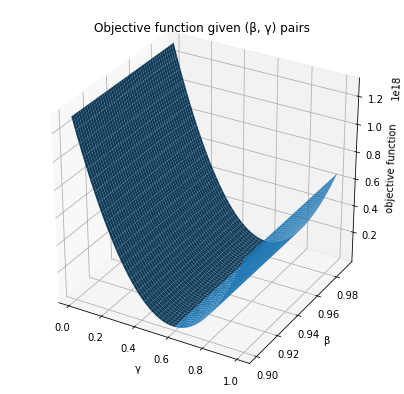

In [16]:
γγ = np.linspace(.01, 1, 50)
ββ = np.linspace(.9, .99, 50)
Y, B = np.meshgrid(γγ,ββ)
func = func_final(Y, B)

fig = plt.figure(figsize = (7,7))
ax = fig.gca(projection='3d')
ax.plot_surface(Y, B, func)
ax.set_xlabel('γ')
ax.set_ylabel('β')
ax.set_zlabel('objective function')
ax.set_title('Objective function given (β, γ) pairs')
plt.show()

# Chapter 3 exercise
- Reference: Rebekah Dix, BootCamp2018

In [17]:
import pickle
import pandas as pd
import numpy as np
import pprint as pprint
import scipy.stats as sts
import matplotlib.pyplot as plt

In [18]:
# Load data
files = ['AAPL', 'C', 'GBX', 'SPY', 'THO']
file_objs = []
for file in files:
    with open('data/' + file, 'rb') as pickle_file:
        file_objs.append(pickle.load(pickle_file))

### 1. Write an orderbook class

In [19]:
# Defind a class that represents a single orderbook
class OrderBook:
    """
    An order book class
    
    Attributes:
        data (dict) : raw data
        time (scalar) : time (in seconds since midnight) of observations
        df (dataframe) : dataframe with price and quantity observations
        P (vector) : vector of prices (with extreme values discarded)
        Q (vector) : vector of quantities (with extreme values discarded)
        midpoint (scalar) : Actual midpoint of the BBO
        gamma (scalar) : intercept of y = gamma + beta * P regression
        beta (scalar) : slope of y = gamma + beta * P regression
        p (scalar) : market clearing price
        
    Methods:
        estimate: estimate parameters γ and β
        plot: plot a particular orderbook
        compare: compare between estimated p0 and actual midpoint
        
    """
    
    def __init__(self, data, lower, upper):
        """
        Inputs:
            lower (scalar) : lower multiplier for what section of data to use 
                             (relative to market midpoint)
            upper (scalar) : upper multiplier for what section of data to use 
                             (relative to market midpoint)
        
        """
        self.data = data[1]
        self.time = data[0]
        self.lower = lower
        self.upper = upper
        df = pd.DataFrame.from_dict(self.data, orient='index')
    
        # Drop unneeded data
        df.columns = ['Quantity', 'Type', 'na','naa']
        df = df.drop(['na', 'naa'], axis = 1)
                
        # Create demand and supply curves
        self.demand = df[df['Type'] == 'B'].sort_index(ascending=False)
        self.supply = df[df['Type'] == 'S'].sort_index()
        self.demand['QD'] = -self.demand['Quantity'].cumsum()
        self.supply['QS'] = self.supply['Quantity'].cumsum()
        
        # Find point where supply = demand
        orders = pd.concat([self.demand, self.supply], sort=True)
        orders = orders.fillna(0)
        orders['Q'] = orders['QD'] + orders['QS']
        self.midpoint = orders[orders.Q < 0].index.values[0]
        
        # Restrict attention to range around equilibrium price
        self.orders = orders[(orders.index > lower * self.midpoint) 
                             & (orders.index < upper * self.midpoint)]
        
        self.Q = self.orders['Q']
        self.P = self.orders.index.values
                
    def estimate(self):
        slope, intercept, r_value, p_value, std_err = sts.linregress(self.P, self.Q)
        self.gamma = intercept
        self.beta = slope
        self.p = - self.gamma/self.beta 

    def plot(self, bookname):
        fig = plt.figure(figsize=(8,5))
        plt.plot(self.demand.index.values, self.demand['QD'], label='Quantity Demanded')
        plt.plot(self.supply.index.values, self.supply['QS'], label='Quantity Supplied')
        p_grid = np.linspace(self.lower * self.midpoint, self.upper * self.midpoint)
        plt.plot(p_grid, self.gamma + self.beta * p_grid, 'r', label='Estimated Equation')
        plt.xlim(0.5 * self.midpoint, 1.5 * self.midpoint)
        plt.xlabel('Price')
        plt.ylabel('Quantity')
        plt.title(bookname + ' Stock at t = %i' %self.time)
        plt.legend()
        plt.show()
        
    def compare(self):
        print("The estimated p_0 is: %f" %self.p)
        print("The actual midpoint of the BBO is: %f" %self.midpoint)

In [20]:
def show_orderbook(file_obj, t, bookname):
    test = OrderBook(file_obj[t], .9, 1.1)
    test.estimate()
    test.plot(bookname)
    test.compare()

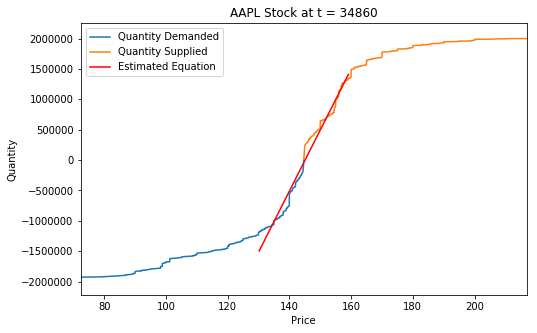

The estimated p_0 is: 145.094175
The actual midpoint of the BBO is: 144.670000


In [21]:
show_orderbook(file_objs[0], 10, 'AAPL')

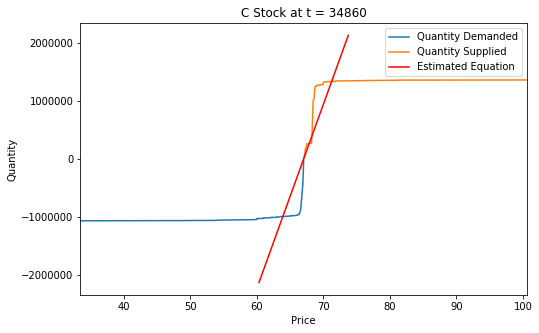

The estimated p_0 is: 67.048602
The actual midpoint of the BBO is: 67.060000


In [22]:
show_orderbook(file_objs[1], 10, 'C')

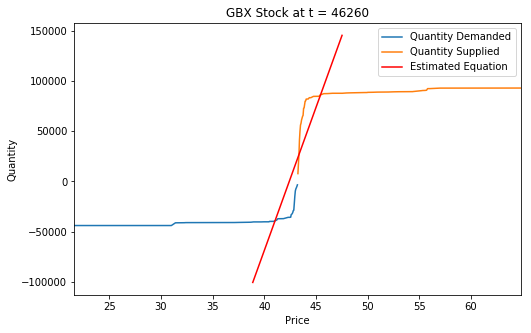

The estimated p_0 is: 42.415344
The actual midpoint of the BBO is: 43.200000


In [23]:
show_orderbook(file_objs[2], 200, 'GBX')

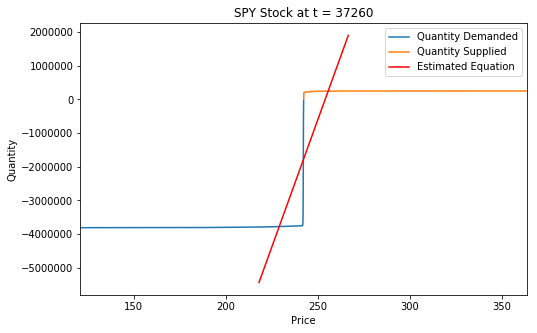

The estimated p_0 is: 253.919781
The actual midpoint of the BBO is: 242.270000


In [24]:
show_orderbook(file_objs[3], 50, 'SPY')

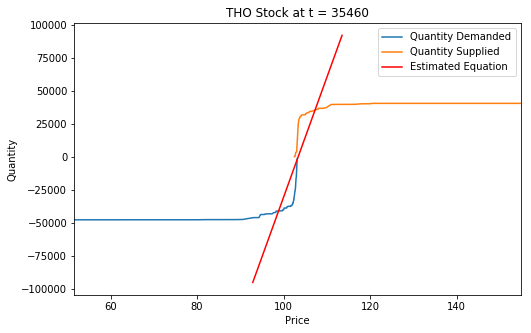

The estimated p_0 is: 103.355414
The actual midpoint of the BBO is: 103.190000


In [25]:
show_orderbook(file_objs[4], 20, 'THO')

### 2. plot estimated values of $\hat{\beta} = \frac{2\sigma_u}{\sqrt{\Sigma_0}}$ throughout the day

In [26]:
def plot_βhat(file_obj, title):
    βhat = np.zeros(len(file_obj), dtype=np.float64)
    
    for i in range(len(file_obj)):
        book = OrderBook(file_obj[i], .9, 1.1)
        book.estimate()
        βhat[i] = book.beta
    
    fig = plt.figure(figsize=(8,5))
    plt.plot(βhat)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(r'$\frac{2\sigma_u}{\sqrt{\Sigma_0}}$', rotation=0, fontsize=20, labelpad=20)
    plt.show()

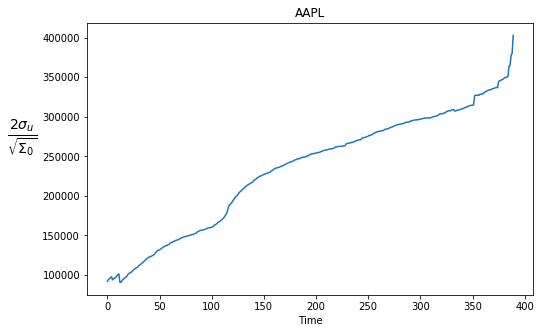

In [27]:
plot_βhat(file_objs[0], 'AAPL')

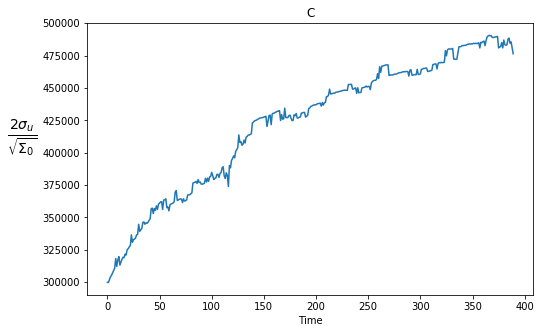

In [28]:
plot_βhat(file_objs[1], 'C')

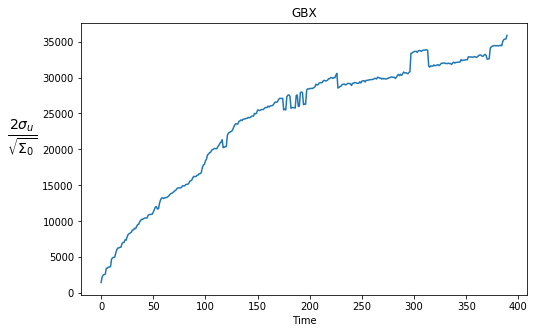

In [29]:
plot_βhat(file_objs[2], 'GBX')

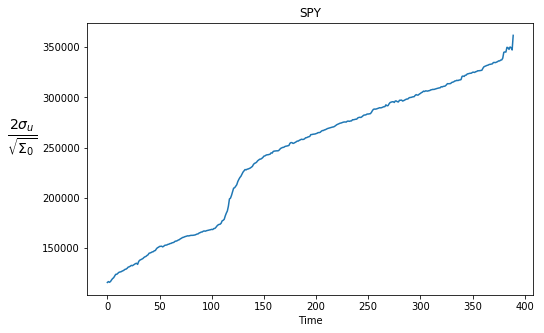

In [30]:
plot_βhat(file_objs[3], 'SPY')

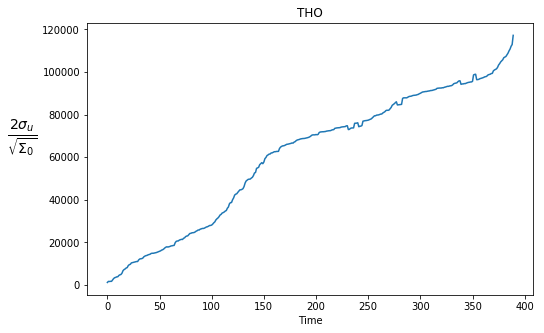

In [31]:
plot_βhat(file_objs[4], 'THO')

### 3. Compare and contrast estimated price and actual midpoint

In [32]:
def compare_p(file_obj, title):
    p_est = np.zeros(len(file_obj))
    p_true = np.zeros(len(file_obj))
    for i in range(len(file_obj)):
        book = OrderBook(file_obj[i], .9, 1.1)
        book.estimate()
        p_est[i] = book.p
        p_true[i] = book.midpoint
    
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
    ax1.plot(p_est, label='Estimated p')
    ax1.plot(p_true, label='Actual p')
    ax1.set_title(title)
    ax1.legend()
    ax1.set_xlabel('Time')
    ax1.set_ylabel(r'$p$', rotation = 0)
    
    ax2.plot(p_est - p_true, label = 'Estimated - Actual')
    ax2.set_title(title + ' difference in estimated and actual')
    ax2.legend()
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Difference')
    plt.show()

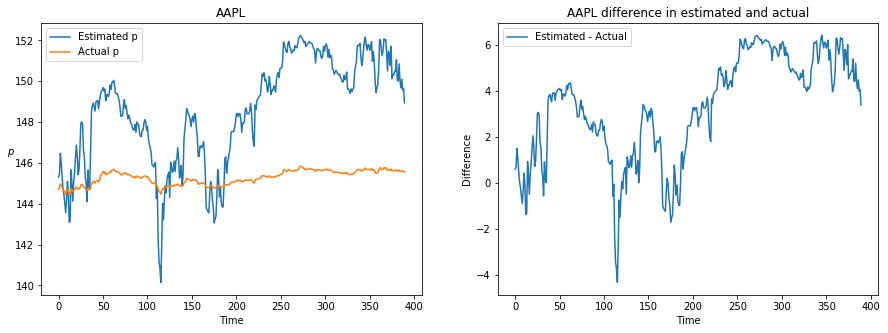

In [33]:
compare_p(file_objs[0], 'AAPL')

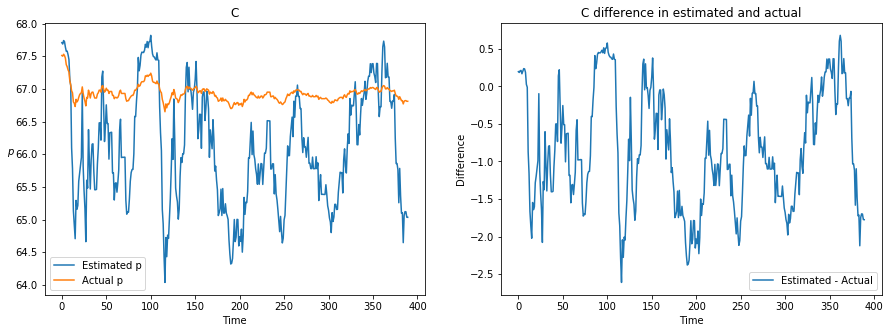

In [34]:
compare_p(file_objs[1], 'C')

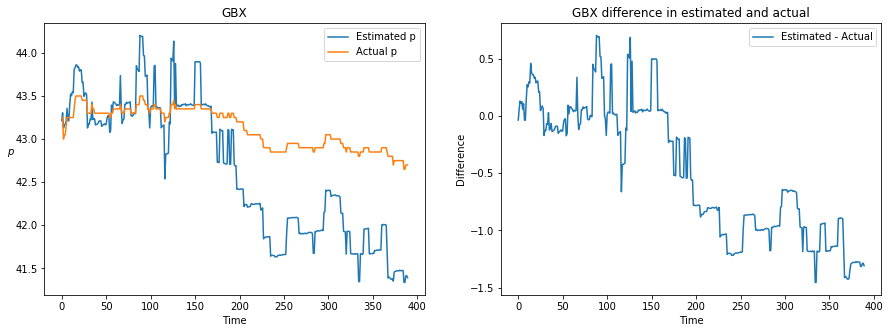

In [35]:
compare_p(file_objs[2], 'GBX')

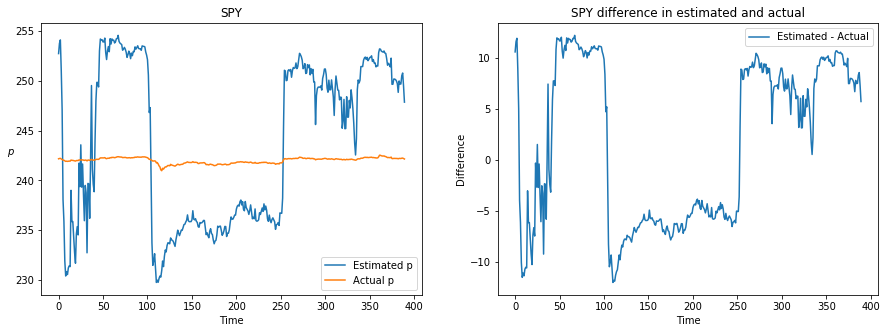

In [36]:
compare_p(file_objs[3], 'SPY')

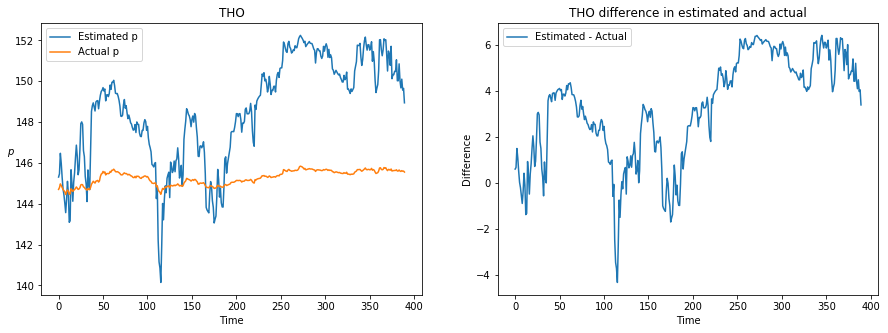

In [37]:
compare_p(file_objs[0], 'THO')

- The estimated price is much more volentile than the actual midpoint, but overall it follows the same trend as the actual midpoint.
- This might comes from the fact that we are only doing the estimation in discrete time, so it is inaccurate.

- For contrasts between different tickers, we observe that if the actual price is more volatile, i.e. 'AAPL', 'SPY' and 'THO', the difference between actual and estimated price is much larger, which can be observed on the right hand side graph, for these three tickers, the scale on y-axis are much larger than 'C' and 'GBX'.
- I would say that this agrees with our intuition, when the actual data is more volatile, the estimated value is more likely to be far away from the actual midpoint.